### P01 - Text Generation with LLM

This notebook will cover:
1. How to load an LLM from HuggingFace?
2. How to generate a token from the model output tensors?
3. Prefill and decode: optimizing token generation over multiple steps

#### Import required packages

In [34]:
import matplotlib.pyplot as plt
import time
import torch
from transformers import AutoModelForCausalLM, AutoTokenizer

#### Load an LLM from HuggingFace

In [2]:
# create model and tokenizer
model_name = "./models/gpt2"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForCausalLM.from_pretrained(model_name)

In [3]:
# check model architecture
print(type(model))
print(model)
model.to("cuda")
print(model.device)

<class 'transformers.models.gpt2.modeling_gpt2.GPT2LMHeadModel'>
GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(50257, 768)
    (wpe): Embedding(1024, 768)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-11): 12 x GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D()
          (c_proj): Conv1D()
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D()
          (c_proj): Conv1D()
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  )
  (lm_head): Linear(in_features=768, out_features=50257, bias=False)
)
cuda:0


In [4]:
# check tokenizer
print(type(tokenizer))
print(f"vocab size: {tokenizer.vocab_size}")

<class 'transformers.models.gpt2.tokenization_gpt2_fast.GPT2TokenizerFast'>
vocab size: 50257


#### Generate a token from the model output tensors

In [5]:
# tokenize input
prompt = "The quick brown fox jumped over the"
inputs = tokenizer(prompt, return_tensors="pt").to("cuda")
print(type(inputs))
for k,v in inputs.items():
    print(f"{k}: {v.shape}: {v}")
print(tokenizer.decode(inputs["input_ids"][0]))

<class 'transformers.tokenization_utils_base.BatchEncoding'>
input_ids: torch.Size([1, 7]): tensor([[  464,  2068,  7586, 21831, 11687,   625,   262]], device='cuda:0')
attention_mask: torch.Size([1, 7]): tensor([[1, 1, 1, 1, 1, 1, 1]], device='cuda:0')
The quick brown fox jumped over the


In [6]:
# execute a forward pass
with torch.no_grad():
    # unpack inputs dict and pass as keyword arguments
    outputs = model(**inputs)

logits = outputs.logits
print(logits.shape)

torch.Size([1, 7, 50257])


In [7]:
# get the most likely next token
last_logits = logits[0, -1, :]
print(last_logits.shape)
next_token_id = last_logits.argmax()
print(next_token_id)
tokenizer.decode(next_token_id)

torch.Size([50257])
tensor(13990, device='cuda:0')


' fence'

In [8]:
# get the 10 most likely next tokens
top_k = torch.topk(last_logits, k=10)
tokens = [tokenizer.decode(tk) for tk in top_k.indices]
print(",".join(tokens))

 fence, edge, railing, wall, table, tree, top, counter, ground, side


In [9]:
# construct next input
print(f"concat {inputs['input_ids'].shape} and {next_token_id.reshape((1, 1)).shape}")
next_inputs = {
    "input_ids": torch.cat(
        [inputs["input_ids"], next_token_id.reshape((1, 1))],
        dim=1
    ),
    "attention_mask": torch.cat(
        [inputs["attention_mask"], torch.tensor([[1]], device="cuda")],
        dim=1
    ),
}
print(f"next inputs: {next_inputs['input_ids'].shape}")

concat torch.Size([1, 7]) and torch.Size([1, 1])
next inputs: torch.Size([1, 8])


#### Baseline

In [10]:
def generate_token(inputs):
    with torch.no_grad():
        outputs = model(**inputs)
    logits = outputs.logits
    last_logits = logits[0, -1, :]
    next_token_id = last_logits.argmax()
    return next_token_id

Total time to generate 10 tokens: 56.84232711791992 ms
The quick brown fox jumped over the
[' fence', ' and', ' ran', ' to', ' the', ' other', ' side', ' of', ' the', ' fence']


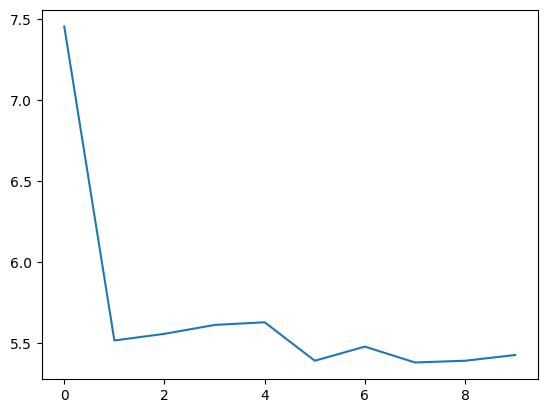

In [26]:
# measure time to generate 10 tokens
count = 10
target_device = "cuda"
# target_device = "cpu"

generated_tokens = []
model = model.to(target_device)
next_inputs = inputs.to(target_device)
durations_ms = []
for _ in range(count):
    t0 = time.time()
    next_token_id = generate_token(next_inputs)
    durations_ms += [(time.time() - t0) * 1e3]
    
    next_inputs = {
        "input_ids": torch.cat(
            [next_inputs["input_ids"], next_token_id.reshape((1, 1))],
            dim=1),
        "attention_mask": torch.cat(
            [next_inputs["attention_mask"], torch.tensor([[1]], device=target_device)],
            dim=1),
    }
    
    next_token = tokenizer.decode(next_token_id)
    generated_tokens.append(next_token)

print(f"Total time to generate {count} tokens: {sum(durations_ms)} ms")
print(prompt)
print(generated_tokens)
# plot durations
plt.plot(durations_ms)
plt.show()

#### KV-cache

In [12]:
def generate_token_with_past(inputs):
    with torch.no_grad():
        outputs = model(**inputs)
    logits = outputs.logits
    last_logits = logits[0, -1, :]
    next_token_id = last_logits.argmax()
    # also return past key/value
    return next_token_id, outputs.past_key_values

In [13]:
# shape: batch_size, num_heads, seq_len, head_dim
def print_past_key_values_shapes(past_key_values):
    if past_key_values is not None:
        for i, layer_past in enumerate(past_key_values):
            if i > 0:
                break
            print(f"Layer {i} key shape: {layer_past[0].shape}, value shape: {layer_past[1].shape}")

55.60016632080078 ms
[' fence', ' and', ' ran', ' to', ' the', ' other', ' side', ' of', ' the', ' fence']


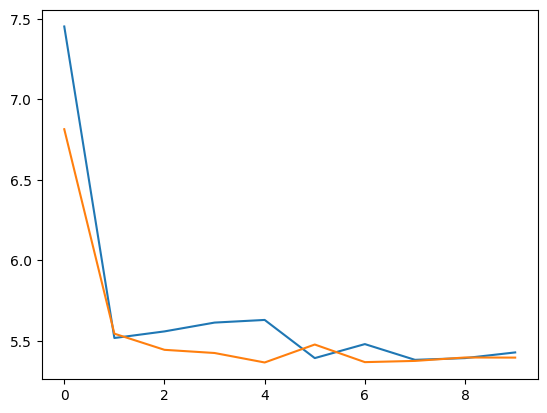

In [33]:
count = 10
target_device = "cuda"
# target_device = "cpu"

generated_tokens = []
next_inputs = inputs.to(target_device)
durations_cached_ms = []
for _ in range(count):
    t0 = time.time()
    next_token_id, past_key_values = generate_token_with_past(next_inputs)
    durations_cached_ms += [(time.time() - t0) * 1e3]
    # print_past_key_values_shapes(past_key_values)
    next_inputs = {
        "input_ids": next_token_id.reshape((1, 1)),
        "attention_mask": torch.cat(
            [next_inputs["attention_mask"], torch.tensor([[1]]).to(target_device)],
            dim=1),
        "past_key_values": past_key_values,
    }
    next_token = tokenizer.decode(next_token_id)
    generated_tokens.append(next_token)

print(f"{sum(durations_cached_ms)} ms")
print(generated_tokens)

# plot durations
plt.plot(durations_ms)
plt.plot(durations_cached_ms)
plt.show()